In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
import ast

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.layers import BatchNormalization

2024-04-02 21:32:45.752975: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 21:32:45.753170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 21:32:46.006018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 21:32:46.767022: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 21:32:53.030679: W tensorflow/compiler/tf2

In [2]:
ptbxl_database_path = 'ptbxl/ptbxl_database.csv'
scp_statements_path = 'ptbxl/scp_statements.csv'

ptbxl = pd.read_csv(ptbxl_database_path, index_col='ecg_id')
scp_statements = pd.read_csv(scp_statements_path, index_col=0)

In [3]:
display(ptbxl.head())
print(ptbxl.shape)   
display(scp_statements.head())
print(scp_statements.shape)

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


(21799, 27)


,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


(71, 12)


In [4]:
print("PTBXL Columns: ")
print(ptbxl.columns)
print("SCP Statements Columns: ")
print(scp_statements.columns)


PTBXL Columns: 
Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr'],
      dtype='object')
SCP Statements Columns: 
Index(['description', 'diagnostic', 'form', 'rhythm', 'diagnostic_class',
       'diagnostic_subclass', 'Statement Category',
       'SCP-ECG Statement Description', 'AHA code', 'aECG REFID', 'CDISC Code',
       'DICOM Code'],
      dtype='object')


In [5]:
scp_statements = scp_statements[scp_statements.diagnostic == 1]
print(scp_statements.shape)

(44, 12)


In [6]:
ptbxl_filtered = ptbxl.filter(['ecg_id', 'filename_lr', 'filename_hr', 'scp_codes', 'strat_fold'])
display(ptbxl_filtered.head())

,filename_lr,filename_hr,scp_codes,strat_fold
ecg_id,,,,
1,records100/00000/00001_lr,records500/00000/00001_hr,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",3
2,records100/00000/00002_lr,records500/00000/00002_hr,"{'NORM': 80.0, 'SBRAD': 0.0}",2
3,records100/00000/00003_lr,records500/00000/00003_hr,"{'NORM': 100.0, 'SR': 0.0}",5
4,records100/00000/00004_lr,records500/00000/00004_hr,"{'NORM': 100.0, 'SR': 0.0}",3
5,records100/00000/00005_lr,records500/00000/00005_hr,"{'NORM': 100.0, 'SR': 0.0}",4


In [7]:
# convert the string in scp_codees to dictionary
ptbxl_filtered['scp_codes'] = ptbxl_filtered['scp_codes'].apply(lambda x: ast.literal_eval(x))

In [8]:
def aggregate_diagnostic(dic):
    tmp = []
    for key in dic.keys():
        if key in scp_statements.index:
            tmp.append(scp_statements.loc[key].diagnostic_class)
    return list(set(tmp))

In [9]:
ptbxl_filtered['diagnostic_superclass'] = ptbxl_filtered['scp_codes'].apply(aggregate_diagnostic)

In [10]:
ptbxl_filtered.head()

,filename_lr,filename_hr,scp_codes,strat_fold,diagnostic_superclass
ecg_id,,,,,
1,records100/00000/00001_lr,records500/00000/00001_hr,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",3,[NORM]
2,records100/00000/00002_lr,records500/00000/00002_hr,"{'NORM': 80.0, 'SBRAD': 0.0}",2,[NORM]
3,records100/00000/00003_lr,records500/00000/00003_hr,"{'NORM': 100.0, 'SR': 0.0}",5,[NORM]
4,records100/00000/00004_lr,records500/00000/00004_hr,"{'NORM': 100.0, 'SR': 0.0}",3,[NORM]
5,records100/00000/00005_lr,records500/00000/00005_hr,"{'NORM': 100.0, 'SR': 0.0}",4,[NORM]


In [11]:
def load_raw_data(df, sampling_rate, path):
    data = []
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [12]:
# split the data into train and test
ecg_data = load_raw_data(ptbxl_filtered, 100, 'ptbxl/')

In [13]:
ecg_data = np.transpose(ecg_data, (0, 2, 1))
ecg_data.shape

(21799, 12, 1000)

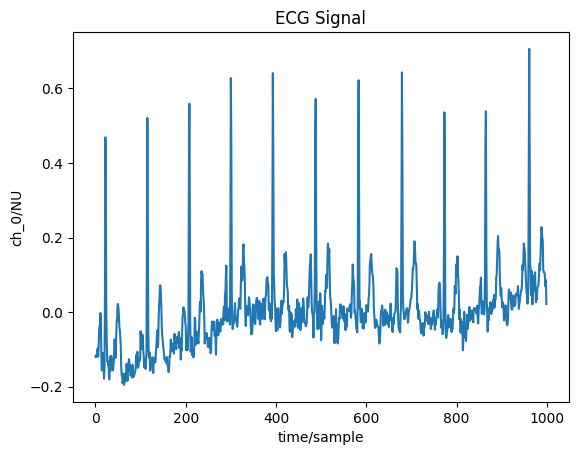

In [14]:
wfdb.plot_items(signal=ecg_data[0][0], title='ECG Signal')

In [15]:
ecg_labels = ptbxl_filtered['diagnostic_superclass'].values

In [16]:
#convert ecg_labels from array of lists to array of strings
ecg_labels = [' '.join(map(str, l)) for l in ecg_labels]

In [17]:
from keras.utils import to_categorical

In [18]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(ecg_labels)
labels = to_categorical(encoded_labels)

In [19]:
# display the labels along with the classes
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
label_mapping

{0: '',
 1: 'CD',
 2: 'CD HYP',
 3: 'CD STTC',
 4: 'CD STTC HYP',
 5: 'HYP',
 6: 'MI',
 7: 'MI CD',
 8: 'MI CD HYP',
 9: 'MI CD STTC',
 10: 'MI CD STTC HYP',
 11: 'MI HYP',
 12: 'MI STTC',
 13: 'MI STTC HYP',
 14: 'NORM',
 15: 'NORM CD',
 16: 'NORM CD HYP',
 17: 'NORM CD STTC',
 18: 'NORM HYP',
 19: 'NORM MI CD HYP',
 20: 'NORM STTC',
 21: 'STTC',
 22: 'STTC HYP'}

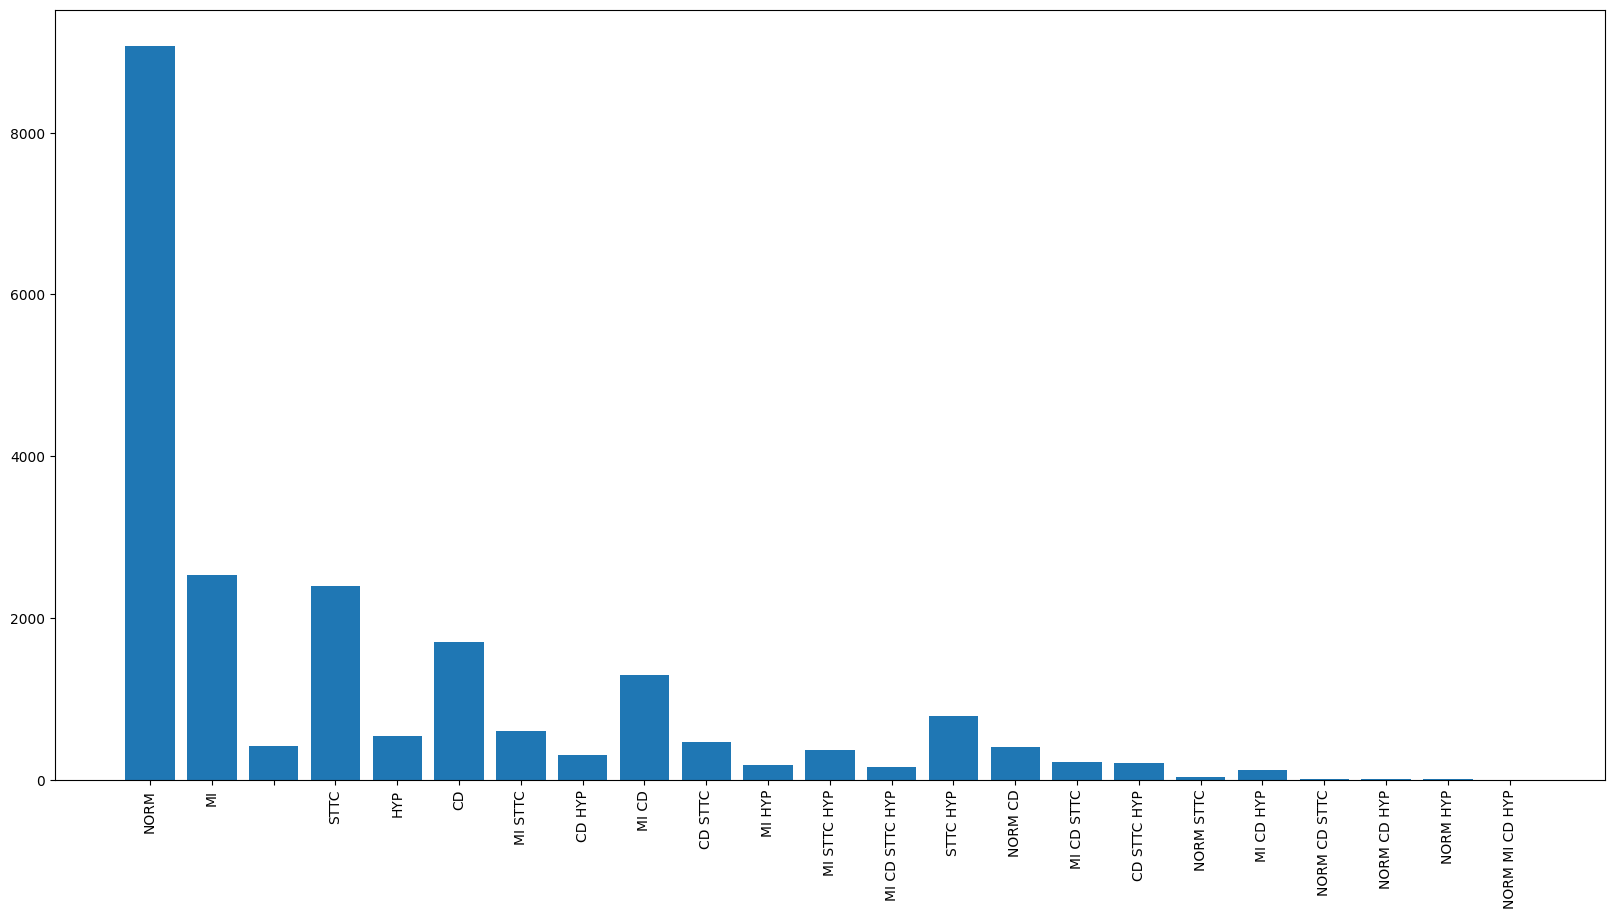

In [20]:
# count the frequency of each diagnostic_superclass in the dataset and plot the distribution
from collections import Counter
from matplotlib import pyplot as plt

counter = Counter(ecg_labels)
keys = counter.keys()
values = counter.values()

plt.figure(figsize=(20, 10))
plt.bar(keys, values)
plt.xticks(rotation='vertical')
plt.show()

In [21]:
# create a subset of ptbxl where the diagnostic_superclass is either 'NORM', 'STTC', 'MI', 'HYP' or 'CD'
ptbxl_filtered_subset = ptbxl_filtered[ptbxl_filtered['diagnostic_superclass'].apply(lambda x: 'NORM' in x or 'STTC' in x or 'MI' in x or 'HYP' in x or 'CD' in x)]

In [22]:
print(ptbxl_filtered_subset.shape)
ptbxl_filtered_subset

(21388, 5)


,filename_lr,filename_hr,scp_codes,strat_fold,diagnostic_superclass
ecg_id,,,,,
1,records100/00000/00001_lr,records500/00000/00001_hr,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",3,[NORM]
2,records100/00000/00002_lr,records500/00000/00002_hr,"{'NORM': 80.0, 'SBRAD': 0.0}",2,[NORM]
3,records100/00000/00003_lr,records500/00000/00003_hr,"{'NORM': 100.0, 'SR': 0.0}",5,[NORM]
4,records100/00000/00004_lr,records500/00000/00004_hr,"{'NORM': 100.0, 'SR': 0.0}",3,[NORM]
5,records100/00000/00005_lr,records500/00000/00005_hr,"{'NORM': 100.0, 'SR': 0.0}",4,[NORM]
...,...,...,...,...,...
21833,records100/21000/21833_lr,records500/21000/21833_hr,"{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...",7,[STTC]
21834,records100/21000/21834_lr,records500/21000/21834_hr,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",4,[NORM]
21835,records100/21000/21835_lr,records500/21000/21835_hr,"{'ISCAS': 50.0, 'SR': 0.0}",2,[STTC]


In [23]:
# print the first entry of the subset
print(ptbxl_filtered_subset.iloc[0])

filename_lr                             records100/00000/00001_lr
filename_hr                             records500/00000/00001_hr
scp_codes                {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
strat_fold                                                      3
diagnostic_superclass                                      [NORM]
Name: 1, dtype: object


In [24]:
filename_lr = []
labels = []
labels_binary = []
for index, row in ptbxl_filtered.iterrows():
    if (row['diagnostic_superclass'] == ['NORM'] or row['diagnostic_superclass'] == ['STTC'] or row['diagnostic_superclass'] == ['MI'] or row['diagnostic_superclass'] == ['HYP'] or row['diagnostic_superclass'] == ['CD']):
        filename_lr.append(row['filename_lr'])
        labels.append(row['diagnostic_superclass'][0])
        if (row['diagnostic_superclass'] == ['NORM']):
            labels_binary.append(1)
        else:
            labels_binary.append(0)


In [25]:
filename_lr = np.array(filename_lr)
labels = np.array(labels)

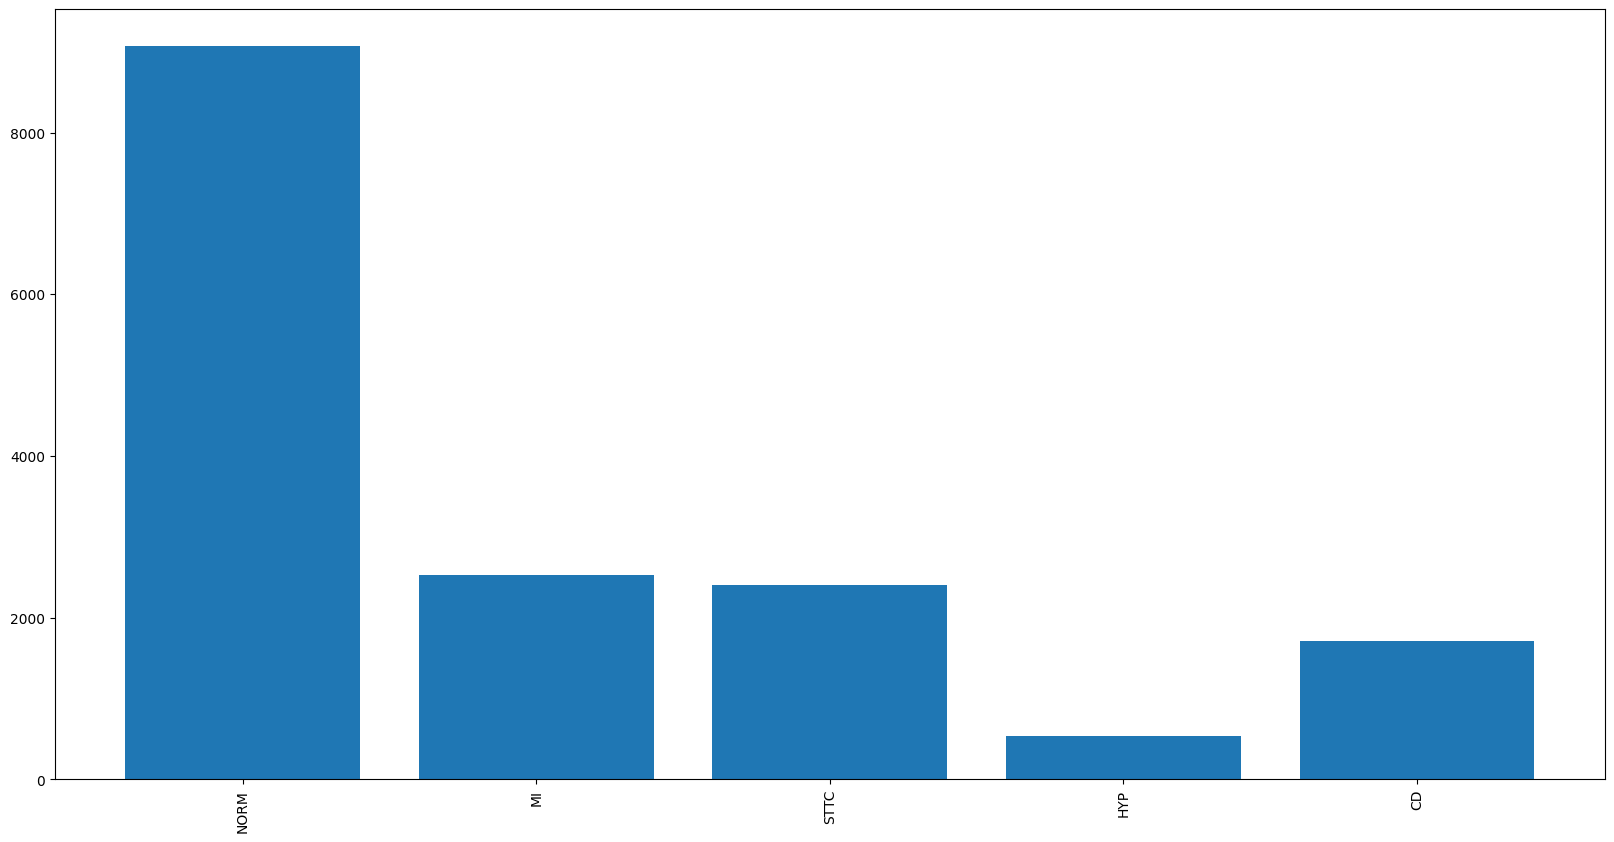

In [26]:
# count the frequency of each label and plot it in a bar graph
counter = Counter(labels)
keys = counter.keys()
values = counter.values()

plt.figure(figsize=(20, 10))
plt.bar(keys, values)
plt.xticks(rotation='vertical')
plt.show()

In [27]:
for count in counter:
    print(count, '\t', counter[count])

NORM 	 9069
MI 	 2532
STTC 	 2400
HYP 	 535
CD 	 1708


In [28]:
def read_data(filename_lr, labels):
    data = []
    for f in filename_lr:
        data.append(wfdb.rdsamp('ptbxl/' + f)[0])
    return np.array(data), labels

In [29]:
data = read_data(filename_lr, labels)

In [30]:
X = data[0]
Y = data[1]
X = np.transpose(X, (0 , 2, 1))
np.unique(Y)

array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype='<U4')

In [31]:
print(X.shape)
print(Y.shape)

(16244, 12, 1000)
(16244,)


In [32]:
# encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(Y)
print(encoded_labels)
Y = to_categorical(encoded_labels)

[3 3 3 ... 4 3 3]


In [33]:
print(X[0])
print(Y[0])

[[-0.119 -0.116 -0.12  ...  0.069  0.086  0.022]
 [-0.055 -0.051 -0.044 ...  0.     0.004 -0.031]
 [ 0.064  0.065  0.076 ... -0.069 -0.081 -0.054]
 ...
 [-0.026 -0.031 -0.028 ...  0.024  0.242  0.143]
 [-0.039 -0.034 -0.029 ... -0.041 -0.046 -0.035]
 [-0.079 -0.074 -0.069 ... -0.058 -0.098 -0.12 ]]
[0. 0. 0. 1. 0.]


In [34]:
# divide the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(12995, 12, 1000)
(12995, 5)
(3249, 12, 1000)
(3249, 5)


In [35]:
X_train[1]

array([[ 0.136,  0.145,  0.166, ..., -0.018, -0.029, -0.027],
       [-0.004,  0.01 ,  0.044, ..., -0.047, -0.049, -0.051],
       [-0.14 , -0.135, -0.122, ..., -0.03 , -0.02 , -0.024],
       ...,
       [ 0.175,  0.184,  0.221, ...,  0.016,  0.018,  0.032],
       [-0.01 ,  0.002,  0.04 , ...,  0.159,  0.149,  0.145],
       [-0.274, -0.263, -0.231, ..., -0.306, -0.316, -0.319]])

In [36]:
x_train_lead0 = X_train[:, 0, :]
x_train_lead0 = x_train_lead0.reshape(x_train_lead0.shape[0], x_train_lead0.shape[1], 1)
print(x_train_lead0.shape)

x_test_lead0 = X_test[:, 0, :]
x_test_lead0 = x_test_lead0.reshape(x_test_lead0.shape[0], x_test_lead0.shape[1], 1)
print(x_test_lead0.shape)

(12995, 1000, 1)
(3249, 1000, 1)


In [37]:
def build_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(1000, 1)))
    model.add(BatchNormalization())

    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(1000, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(1000, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

    return model;

In [38]:
model = build_model()
model.summary()

2024-04-02 21:36:58.712020: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-02 21:37:00.390145: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-02 21:37:00.390703: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1000, 64)          448       
                                                                 
 batch_normalization (Batch  (None, 1000, 64)          256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 500, 64)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 64)           24640     
                                                                 
 batch_normalization_1 (Bat  (None, 500, 64)           256       
 chNormalization)                                                
                                                        

In [ ]:
model.fit(x_train_lead0, Y_train, epochs=20, batch_size=10, validation_data=(x_test_lead0, Y_test))

In [54]:
# evaluate model
loss, accuracy = model.evaluate(x_test_lead0, Y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

2024-03-30 22:46:09.798828: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-30 22:46:09.835814: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


102/102 [==============================] - 2s 7ms/step - loss: 1.1367 - accuracy: 0.5713
Test loss: 1.1367450952529907
Test accuracy: 0.571252703666687


In [39]:
# write a function to perform the classification for every lead in 12 lead ECG, and plot a table of the results, the rows will contain the lead names and its index and the columns will contain the testing accuracy
def classify_all_leads(X_train, Y_train, X_test, Y_test):
    accuracy = []
    for i in range(12):
        x_train_lead = X_train[:, i, :]
        x_train_lead = x_train_lead.reshape(x_train_lead.shape[0], x_train_lead.shape[1], 1)
        x_test_lead = X_test[:, i, :]
        x_test_lead = x_test_lead.reshape(x_test_lead.shape[0], x_test_lead.shape[1], 1)
        model = build_model()
        model.fit(x_train_lead, Y_train, epochs=20, batch_size=10, validation_data=(x_test_lead, Y_test))
        loss, acc = model.evaluate(x_test_lead, Y_test)
        accuracy.append(acc)
    return accuracy

accuracy = classify_all_leads(X_train, Y_train, X_test, Y_test)
print(accuracy)

2024-04-02 21:40:19.278194: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51980000 exceeds 10% of free system memory.


Epoch 1/20


2024-04-02 21:40:19.991022: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51980000 exceeds 10% of free system memory.
2024-04-02 21:40:23.949056: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-02 21:40:30.499571: I external/local_xla/xla/service/service.cc:168] XLA service 0x7b270ab14b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-02 21:40:30.499640: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-04-02 21:40:30.672911: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712074231.136205   13222 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1300/1300 [==============================] - 30s 12ms/step - loss: 1.8543 - accuracy: 0.3562 - val_loss: 1.4035 - val_accuracy: 0.5279
Epoch 2/20
1300/1300 [==============================] - 15s 11ms/step - loss: 1.4979 - accuracy: 0.4424 - val_loss: 1.3559 - val_accuracy: 0.5516
Epoch 3/20
1300/1300 [==============================] - 15s 12ms/step - loss: 1.4191 - accuracy: 0.4871 - val_loss: 1.2920 - val_accuracy: 0.5522
Epoch 4/20
1300/1300 [==============================] - 15s 11ms/step - loss: 1.3639 - accuracy: 0.5107 - val_loss: 1.2504 - val_accuracy: 0.5531
Epoch 5/20
1300/1300 [==============================] - 15s 11ms/step - loss: 1.3374 - accuracy: 0.5194 - val_loss: 1.2385 - val_accuracy: 0.5531
Epoch 6/20
1300/1300 [==============================] - 15s 11ms/step - loss: 1.3016 - accuracy: 0.5299 - val_loss: 1.2187 - val_accuracy: 0.5546
Epoch 7/20
1300/1300 [==============================] - 15s 12ms/step - loss: 1.2697 - accuracy: 0.5376 - val_loss: 1.2121 - val_accura

2024-04-02 21:45:23.799948: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-02 21:45:23.828137: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


102/102 [==============================] - 1s 10ms/step - loss: 1.1278 - accuracy: 0.5842
Epoch 1/20


2024-04-02 21:45:25.066285: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51980000 exceeds 10% of free system memory.
2024-04-02 21:45:25.115233: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51980000 exceeds 10% of free system memory.


1300/1300 [==============================] - 17s 10ms/step - loss: 2.1604 - accuracy: 0.2459 - val_loss: 1.3916 - val_accuracy: 0.5140
Epoch 2/20
1300/1300 [==============================] - 14s 11ms/step - loss: 1.6324 - accuracy: 0.3028 - val_loss: 1.3953 - val_accuracy: 0.5362
Epoch 3/20
1300/1300 [==============================] - 14s 10ms/step - loss: 1.5169 - accuracy: 0.3762 - val_loss: 1.3259 - val_accuracy: 0.5589
Epoch 4/20
1300/1300 [==============================] - 14s 11ms/step - loss: 1.4444 - accuracy: 0.4272 - val_loss: 1.2668 - val_accuracy: 0.5663
Epoch 5/20
1300/1300 [==============================] - 13s 10ms/step - loss: 1.3826 - accuracy: 0.4690 - val_loss: 1.2249 - val_accuracy: 0.5694
Epoch 6/20
1300/1300 [==============================] - 14s 11ms/step - loss: 1.3337 - accuracy: 0.4995 - val_loss: 1.1873 - val_accuracy: 0.5731
Epoch 7/20
1300/1300 [==============================] - 14s 11ms/step - loss: 1.2949 - accuracy: 0.5170 - val_loss: 1.1612 - val_accura

2024-04-02 21:49:59.969130: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51980000 exceeds 10% of free system memory.


1300/1300 [==============================] - 17s 11ms/step - loss: 1.8223 - accuracy: 0.3320 - val_loss: 1.3218 - val_accuracy: 0.5303
Epoch 2/20
1300/1300 [==============================] - 14s 11ms/step - loss: 1.4475 - accuracy: 0.4298 - val_loss: 1.2938 - val_accuracy: 0.5457
Epoch 3/20
1300/1300 [==============================] - 14s 11ms/step - loss: 1.4062 - accuracy: 0.4569 - val_loss: 1.2776 - val_accuracy: 0.5512
Epoch 4/20
1300/1300 [==============================] - 14s 11ms/step - loss: 1.3670 - accuracy: 0.4907 - val_loss: 1.2695 - val_accuracy: 0.5503
Epoch 5/20
1300/1300 [==============================] - 14s 11ms/step - loss: 1.3400 - accuracy: 0.5021 - val_loss: 1.2498 - val_accuracy: 0.5512
Epoch 6/20
1300/1300 [==============================] - 14s 11ms/step - loss: 1.3197 - accuracy: 0.5122 - val_loss: 1.2461 - val_accuracy: 0.5509
Epoch 7/20
1300/1300 [==============================] - 13s 10ms/step - loss: 1.2885 - accuracy: 0.5214 - val_loss: 1.2362 - val_accura

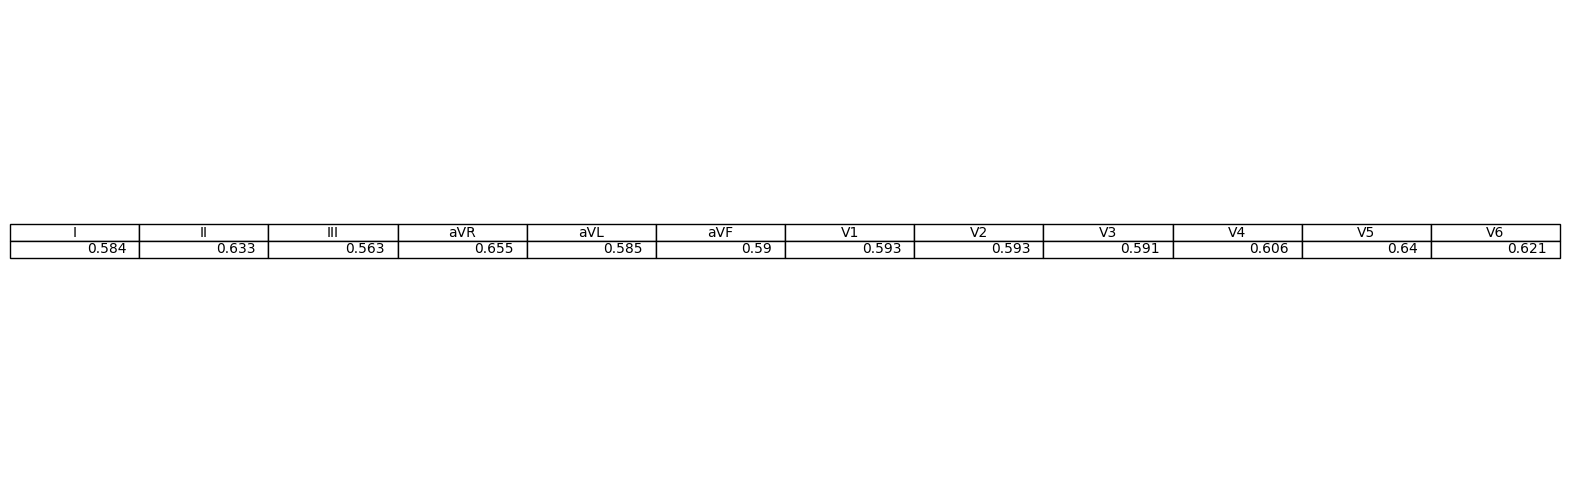

In [69]:
accuracy = [round(acc, 3) for acc in accuracy]

fig, ax = plt.subplots(figsize=(20, 6))
ax.axis('off')
table = ax.table(cellText=accuracy_table.values, colLabels=accuracy_table.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.show()

In [71]:
# create a dataframe of accuracies
lead_names = ['Lead I', 'Lead II', 'Lead III', 'Lead aVR', 'Lead aVL', 'Lead aVF', 'Lead V1', 'Lead V2', 'Lead V3', 'Lead V4', 'Lead V5', 'Lead V6']
accuracy_table = pd.DataFrame(accuracy, columns=['Accuracy'])
accuracy_table['Lead Index'] = range(12)
accuracy_table['Lead Name'] = lead_names
accuracy_table = accuracy_table[['Lead Index', 'Lead Name', 'Accuracy']]
accuracy_table

,Lead Index,Lead Name,Accuracy
0,0,Lead I,0.584
1,1,Lead II,0.633
2,2,Lead III,0.563
3,3,Lead aVR,0.655
4,4,Lead aVL,0.585
5,5,Lead aVF,0.590
6,6,Lead V1,0.593
7,7,Lead V2,0.593
8,8,Lead V3,0.591
9,9,Lead V4,0.606


## Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
clf.fit(x_train_lead0, Y_train)

predictions = clf.predict(x_test_lead0)



In [99]:
rounded_labels = np.argmax(Y_test, axis=1)
accuracy = accuracy_score(rounded_labels, predictions)
print(f"Test Score: {accuracy}")

Test Score: 0.5774084333641121


### Using multiple leads

In [56]:
# use leads 1, 3, 5 and 11 combined for training and testing
x_train_lead13511 = X_train[:, [1, 3, 5, 11], :]
x_train_lead13511 = x_train_lead13511.reshape(x_train_lead13511.shape[0], 4, x_train_lead13511.shape[2])
print(x_train_lead13511.shape)

x_test_lead13511 = X_test[:, [1, 3, 5, 11], :]
x_test_lead13511 = x_test_lead13511.reshape(x_test_lead13511.shape[0], 4, x_test_lead13511.shape[2])
print(x_test_lead13511.shape)


(12995, 4, 1000)
(3249, 4, 1000)


Using Leads : 2, 4, 6 and 12

In [59]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                padding='same', input_shape=(4, 1000)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                padding='same', input_shape=(4, 1000)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                padding='same', input_shape=(4, 1000)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model.fit(x_train_lead13511, Y_train, batch_size=10, epochs=20, validation_data=(x_test_lead13511, Y_test))

Epoch 1/20
1300/1300 [==============================] - 26s 10ms/step - loss: 1.2415 - accuracy: 0.5580 - val_loss: 1.2648 - val_accuracy: 0.5565
Epoch 2/20
1300/1300 [==============================] - 11s 9ms/step - loss: 1.1919 - accuracy: 0.5708 - val_loss: 1.2399 - val_accuracy: 0.5571
Epoch 3/20
1300/1300 [==============================] - 12s 9ms/step - loss: 1.1457 - accuracy: 0.5825 - val_loss: 1.2708 - val_accuracy: 0.5580
Epoch 4/20
1300/1300 [==============================] - 12s 9ms/step - loss: 1.0839 - accuracy: 0.5993 - val_loss: 1.2623 - val_accuracy: 0.5633
Epoch 5/20
1300/1300 [==============================] - 12s 9ms/step - loss: 1.0107 - accuracy: 0.6226 - val_loss: 1.2794 - val_accuracy: 0.5556
Epoch 6/20
1300/1300 [==============================] - 12s 9ms/step - loss: 0.9220 - accuracy: 0.6593 - val_loss: 1.3114 - val_accuracy: 0.5257
Epoch 7/20
1300/1300 [==============================] - 12s 9ms/step - loss: 0.8160 - accuracy: 0.7004 - val_loss: 1.3712 - val_a

In [60]:
loss, accuracy = model.evaluate(x_test_lead13511, Y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

102/102 [==============================] - 1s 5ms/step - loss: 2.8222 - accuracy: 0.5503
Test loss: 2.8222031593322754
Test accuracy: 0.5503231883049011


## Binary classification

In [106]:
Y_binary = labels_binary
Y_binary = np.array(labels_binary)
Y_binary.shape

(16244,)

In [108]:
X_train_binary, X_test_binary,  Y_train_binary, Y_test_binary = train_test_split(X, Y_binary, test_size=0.2, random_state=42)

In [120]:
print(X_train_binary.shape)
print(Y_train_binary.shape)

(12995, 12, 1000)
(12995,)


array([1, 1, 0, ..., 1, 1, 1])

In [117]:
X_train_binary_lead0 = X_train_binary[:, [1, 3, 5, 11], :]
X_test_binary_lead0 = X_test_binary[:, 0, :]

In [115]:
modelBinary = Sequential([
        Conv1D(64, 3, activation='sigmoid', input_shape=(4, 1000), padding='same'),
        MaxPooling1D(2),
        Dropout(0.3),
        Conv1D(128, 3, activation='sigmoid', padding='same'),
        MaxPooling1D(2),
        Conv1D(256, 3, activation='sigmoid', padding='same'),
        Dropout(0.3),
        GlobalAveragePooling1D(),
        Dense(128, activation='sigmoid'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  
    ])


In [116]:
modelBinary.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics='accuracy')

In [130]:
# with tf.device('/cpu:0'):
modelBinary.fit(X_train_binary_lead0, Y_train_binary, epochs=10, batch_size=32, validation_data=(X_test_binary_lead0, Y_test_binary))

Epoch 1/10
407/407 [==============================] - 9s 16ms/step - loss: 0.6860 - accuracy: 0.5601 - val_loss: 0.6879 - val_accuracy: 0.5512
Epoch 2/10
407/407 [==============================] - 6s 15ms/step - loss: 0.6863 - accuracy: 0.5601 - val_loss: 0.6879 - val_accuracy: 0.5512
Epoch 3/10
407/407 [==============================] - 6s 15ms/step - loss: 0.6864 - accuracy: 0.5601 - val_loss: 0.6879 - val_accuracy: 0.5512
Epoch 4/10
407/407 [==============================] - 6s 15ms/step - loss: 0.6863 - accuracy: 0.5601 - val_loss: 0.6879 - val_accuracy: 0.5512
Epoch 5/10
407/407 [==============================] - 6s 15ms/step - loss: 0.6863 - accuracy: 0.5601 - val_loss: 0.6879 - val_accuracy: 0.5512
Epoch 6/10
407/407 [==============================] - 6s 16ms/step - loss: 0.6859 - accuracy: 0.5601 - val_loss: 0.6879 - val_accuracy: 0.5512
Epoch 7/10
407/407 [==============================] - 6s 16ms/step - loss: 0.6862 - accuracy: 0.5601 - val_loss: 0.6879 - val_accuracy: 0.5512

In [5]:
x_train.shape

NameError: name 'x_train' is not defined

In [4]:
model = Sequential([
    Conv1D(64, 3, activation='sigmoid', input_shape=, padding='same'),
    MaxPooling1D(2),
    Dropout(0.3),
    Conv1D(128, 3, activation='sigmoid', padding='same'),
    MaxPooling1D(2),
    Conv1D(256, 3, activation='sigmoid', padding='same'),
    Dropout(0.3),
    GlobalAveragePooling1D(),
    Dense(128, activation='sigmoid'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics='accuracy')
model.fit(X_train, Y_train_binary, epochs=20, batch_size=32, validation_data=(X_test, Y_test))

NameError: name 'Sequential' is not defined